## Imports

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import time
from math import sqrt

import matplotlib.pyplot as plt

import dlc_practical_prologue

## Useful functions

In [2]:
def mean(x):
    return sum(x)/len(x)

def var(x):
    u = mean(x)
    return sum([(v-u)**2 for v in x])/len(x)

In [3]:
def number_parameters(model):   # Returns the number of parameter of a given model
    return sum(p.numel() for p in model.parameters())

## Load data

In [4]:
N = 1000

x_train, y_train, y_train_classes, x_test, y_test, y_test_classes = \
dlc_practical_prologue.generate_pair_sets(N)

assert x_train.shape == torch.Size([N, 2, 14, 14])    # float32
assert y_train.shape == torch.Size([N])               # int64
assert y_train_classes.shape == torch.Size([N, 2])    # int64

assert x_test.shape == torch.Size([N, 2, 14, 14])
assert y_test.shape == torch.Size([N])
assert y_test_classes.shape == torch.Size([N, 2])

In [5]:
if torch.cuda.is_available():  
    dev = "cuda:0"
else:  
    dev = "cpu"  
device = torch.device(dev)

## Normalize input

In [6]:
# Normalizing using ONLY x_train data

x_list = torch.flatten(x_train).tolist()

m = mean(x_list)
v = var(x_list)
x_train = x_train.sub(m).div(sqrt(v))
x_test = x_test.sub(m).div(sqrt(v))

## -----------------------------------------------------------------------------------------------

## Define models 

# Model 0
Is a naive MLP

In [7]:
## Is a naive Multi Layer Perceptron, composed of fully connected linear layers.

class model_0(nn.Module):   
    def __init__(self, ns = [392,128,64,2]):
        super().__init__()
        layers = [nn.Linear(n_in, n_out) for n_in, n_out in zip(ns[:-1], ns[1:])]   
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = torch.flatten(x,1)          # flatten the 2 images in one vector (but keeping batch size)
        for layer in self.layers[:-1]:
            x = layer(x).relu()
            
        x = self.layers[-1](x) 
        return x

model_test = model_0()
model_test(x_train[0:2])    
print(number_parameters(model_0()))

58690


# MODEL 1

Is a simple CNN of **2 Conv Layers** -- 
4 versions of it are implemented:
 * straightforward CNN (model_1)
 * **Finally, I think this one is to simple to justify an intermediate loss without digit prediction** -> Not present
 * with the two images composing the input treated identically and independently (model_1_ws)
 * with the two images composing the input treated identically and independently + Digit predictions for aux loss (model_1_ws_aux2)

In [48]:
class model_1(nn.Module):                 
    def __init__(self):
        super(model_1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)

        self.dense1 = nn.Linear(2304, 2)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.leaky_relu(self.conv2(x))
        
        x = torch.flatten(x, 1)
        
        x = self.dense1(x)
        return x

model_test = model_1()
model_test(x_train[0:2])
print(number_parameters(model_test))

13154


In [49]:
class model_1_aux2(nn.Module):                 
    def __init__(self):
        super(model_1_aux2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)

        self.dense_d1 = nn.Linear(2304, 10)
        self.dense_d2 = nn.Linear(2304, 10)
        self.dense = nn.Linear(20, 2)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.leaky_relu(self.conv2(x))
        
        x = torch.flatten(x, 1)
        
        d1 = self.dense_d1(x)
        d2 = self.dense_d2(x)
        
        x = torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1)
        
        x = self.dense(x)
        return x, d1, d2

model_test = model_1_aux2()
model_test(x_train[0:2])
print(number_parameters(model_test))

54686


In [52]:
class model_1_ws(nn.Module):    
    def __init__(self):
        super(model_1_ws, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)

        self.dense1 = nn.Linear(2304, 2)
        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.max_pool2d(d1, kernel_size=2) 
        d1 = F.leaky_relu(self.conv2(d1))
      
        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.max_pool2d(d2, kernel_size=2) 
        d2 = F.leaky_relu(self.conv2(d2))
        
        x = torch.cat((d1, d2), 2)
        x = torch.flatten(x, 1)
        
        x = self.dense1(x)      
        return x

model_test = model_1_ws()
model_test(x_train[0:2])
print(number_parameters(model_test))

6770


In [53]:
class model_1_ws_aux2(nn.Module):                 
    def __init__(self):
        super(model_1_ws_aux2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)

        self.dense1 = nn.Linear(2304, 10)
        self.dense2 = nn.Linear(20, 2)
        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.max_pool2d(d1, kernel_size=2) 
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = torch.flatten(d1, 1)
        d1 = self.dense1(d1)
        
        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.max_pool2d(d2, kernel_size=2) 
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = torch.flatten(d2, 1)
        d2 = self.dense1(d2)
        
        x = F.leaky_relu(torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1))
        x = torch.flatten(x, 1)
        
        x = F.leaky_relu(self.dense2(x))
        
        return x,d1,d2

    
model_test = model_1_ws_aux2()
model_test(x_train[0:2])
print(number_parameters(model_test))

31508


# MODEL 2

Is a more complex CNN, of **3 conv Layers** -- 
4 versions of it are implemented:
 * straightforward CNN (model_2)
 * !!NOT WORKING!! with intermediate output for auxiliary loss (model_2_aux1)
 * with the two images composing the input treated identically and independently (model_2_ws)
 * with the two images composing the input treated identically and independently + Digit predictions for aux loss (model_2_ws_aux2) **currently our best model**

In [13]:
class model_2(nn.Module):
    def __init__(self):
        super(model_2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) # NEW size
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(3200, 2)

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        
        x = torch.flatten(x, 1)
        x = self.dense1(x)

        return x

model_test = model_2()
model_test(x_train[0:2])
print(number_parameters(model_test))

113506


In [14]:
class model_2_aux1(nn.Module):
    def __init__(self):
        super(model_2_aux1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=2)
        
        self.dense1_intermediate = nn.Linear(3136, 2)
        self.dense1 = nn.Linear(3200, 2)

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
                         
        x_ = torch.flatten(x, 1)
        x_ = self.dense1_intermediate(x_)                   
         
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
                         
        x = torch.flatten(x, 1)
        x = self.dense1(x)
        
        return x,x_

model_test = model_2_aux1()
model_test(x_train[0:2])
print(number_parameters(model_test))

119780


In [15]:
class model_2_ws(nn.Module):  
    def __init__(self):
        super(model_2_ws, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(6400, 2)

    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = F.max_pool2d(d1, kernel_size=2) 
        d1 = F.leaky_relu(self.conv3(d1))
        d1 = F.leaky_relu(self.conv4(d1))

        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = F.max_pool2d(d2, kernel_size=2)
        d2 = F.leaky_relu(self.conv3(d2))
        d2 = F.leaky_relu(self.conv4(d2))

        x = torch.cat((d1, d2), 2)
        x = torch.flatten(x, 1)
        x = self.dense1(x)
        return x

model_test = model_2_ws()
model_test(x_train[0:2])
print(number_parameters(model_test))

56114


In [16]:
class model_2_aux2(nn.Module):
    def __init__(self):
        super(model_2_aux2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=2)
        
        self.dense_d1 = nn.Linear(3200, 10)
        self.dense_d2 = nn.Linear(3200, 10)
        
        self.dense = nn.Linear(20, 2)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = torch.flatten(x, 1)
                
        d1 = self.dense_d1(x)
        d2 = self.dense_d2(x)
        
        x = F.leaky_relu(torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1))
        x = self.dense(x)
        return x, d1, d2

model_test = model_2_aux2()
model_test(x_train[0:2])
print(number_parameters(model_test))

171166


In [17]:
class model_2_ws_aux2(nn.Module):
    def __init__(self):
        super(model_2_ws_aux2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) # NEW size
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(3200, 10)
        self.dense2 = nn.Linear(20, 2)
        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = F.max_pool2d(d1, kernel_size=2)
        d1 = F.leaky_relu(self.conv3(d1))
        d1 = F.leaky_relu(self.conv4(d1))
        d1 = torch.flatten(d1, 1)
        d1 = self.dense1(d1)

        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = F.max_pool2d(d2, kernel_size=2)
        d2 = F.leaky_relu(self.conv3(d2))
        d2 = F.leaky_relu(self.conv4(d2))
        d2 = torch.flatten(d2, 1)
        d2 = self.dense1(d2)
        
        x = torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1)
        x = self.dense2(x)
        return x, d1, d2

model_test = model_2_ws_aux2()
model_test(x_train[0:2])
print(number_parameters(model_test))

139028


## Training/Evaluation function

In [68]:
def train_model(model, 
                 train_input,
                 train_target,
                 digit_target,
                 epochs, optimizer,
                 loss_function = nn.CrossEntropyLoss(), digit_loss = nn.CrossEntropyLoss(),
                 batch_size=16,
                 output_length = 1,
                 verbose = True):
    """
    Train the given model on given inputs with given parameter
    This training method works for the normal training (output_length ==1) and the 2 versions
    Of auxiliary losses:
    - v1 : one intermediary output that has same loss as final (output_length == 2)
    - v2 : 2 additional outputs in the end corresponding to digits (output_length == 3)
    Verbose parameter : lets you chose if you want to see the loss at each epoch
    
    Returns the training losses at each epoch
    """
    model.train()
    losses = []
    
    for e in range(epochs):
        sum_loss = 0
        
        if output_length == 3:
            sum_loss_digit1 = 0
            sum_loss_digit2 = 0
        
        for x_batch, y_batch, y_digit_batch in zip(train_input.split(batch_size),
                                                    train_target.split(batch_size),
                                                    digit_target.split(batch_size)):
            
            if output_length == 1:
                
                output = model(x_batch)
                loss_total = loss_function(output, y_batch)
                
            elif output_length == 2:
                output, output_intermed = model(x_batch)
                loss_intermed = loss_function(output_intermed, y_batch)
                loss_final  = loss_function(output, y_batch)

                loss_total = loss_final + 0.3*loss_intermed

            elif output_length == 3:

                output, d1, d2 = model(x_batch)

                loss_digit1 = digit_loss(d1, y_digit_batch[..., 0])
                loss_digit2 = digit_loss(d2, y_digit_batch[..., 1])
                loss_final  = loss_function(output, y_batch)

                loss_total = loss_final + 0.5*(loss_digit1 + loss_digit2)

                sum_loss_digit1 += loss_digit1.item()
                sum_loss_digit2 += loss_digit2.item()

            optimizer.zero_grad()
            loss_total.backward()  
            optimizer.step()

            sum_loss += loss_total.item()
            
        losses.append(sum_loss)
        
        if verbose : 
            if output_length == 3 :
                print("Epoch %i: loss %.3f --- loss_d1 %.2f --- loss_d2 %.2f" \
                      % (e,sum_loss, sum_loss_digit1, sum_loss_digit2), end="\r")  
            else :
                print("Epoch %i : loss %.3f" % (e, sum_loss), end = "\r")
    return losses

In [67]:
def evaluate_model(model, 
                   test_input, 
                   test_target, 
                   test_digits = None,
                   output_length = 1):
    """ 
    This evaluation method works for the normal training and the 2 versions
    Of auxiliary losses:
    - v1 : one intermediary output that has same loss as final
    - v2 : 2 additional outputs in the end corresponding to digits
    
    Returns the accuracy on provided data for each output (all auxiliary ones too)
    """
    model.eval()
    
    with torch.no_grad():
        if output_length == 1:
            # Basic training
            out = model(test_input)   
            preds = torch.argmax(out, -1)
            accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
            
            return accuracy * 100, 0, 0
        
        elif output_length == 2:
            # Intermediary loss (Aux v1)
            out = model(test_input) 
        
            preds = torch.argmax(torch.softmax(out[0], -1), axis = -1)
            intermed_preds = torch.argmax(torch.softmax(out[1], -1), axis = -1)

            accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
            accuracy_intermed = (intermed_preds.float() == test_target.float()).sum().item()/preds.size(0)
            
            return accuracy * 100, accuracy_intermed * 100, 0
        
        elif output_length == 3:
            # Digit loss (Aux v2)
            out = model(test_input) 
        
            preds = torch.argmax(torch.softmax(out[0], -1), axis = -1)
            d1 = torch.argmax(torch.softmax(out[1], -1), axis = -1)
            d2 = torch.argmax(torch.softmax(out[2], -1), axis = -1)

            accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
            accuracy_d1 = (d1.float() == test_digits[:, 0].float()).sum().item()/preds.size(0)
            accuracy_d2 = (d2.float() == test_digits[:, 1].float()).sum().item()/preds.size(0)
            
            return accuracy * 100, accuracy_d1 * 100, accuracy_d2 * 100

        else :
            print("Wrong model output")
            return 0

## GridSearch

In [69]:
"""
The following section makes a quick grid search exploration using KFold (K=5) cross validation
It makes *number_training* trains on each fold
It explores different:
- Optimizers : Adam / SGD
- Learning rates (dependant on optimizer)
- Batchsizes
"""

models = [model_0,
          model_1, model_1_ws, model_1_aux2, model_1_ws_aux2,
          model_2, model_2_ws, model_2_aux1, model_2_aux2, model_2_ws_aux2]
models_names = ["model 0",
                "model 1", "model 1 WS", "model 1 AUX 2", "model 1 WS AUX 2",
                "model 2", "model 2 WS", "model 2 AUX 1", "model 2 AUX 2", "model 2 WS AUX 2"]
models_best_cfg = []

lrs = dict()

# lrs["Adam"] = [0.01, 0.005, 0.003, 0.002, 0.001, 0.0005]
# lrs["SGD"] = [0.1, 0.05, 0.01]
# batchsizes = [16, 32]

lrs["Adam"] = [0.003, 0.002, 0.001, 0.0005, 0.0001]
lrs["SGD"] = [0.01]
batchsizes = [16]

epochs = 25
number_training = 2

gridsearch_number = len(lrs["Adam"]) * len(batchsizes) + len(lrs["SGD"]) * len(batchsizes)

model_accuracies = []
model_vars = []
model_parameters = []

nfold = 5
perm = torch.randperm(len(x_train))
folds = perm.split(int(len(x_train) / nfold))

for build_model, model_name in zip(models, models_names):
    
    # Just to evaluate model parameters / output shape
    dummy_model = build_model()
    dummy_output = dummy_model(x_train[0:1])
    if (type(dummy_output) == tuple):
        output_length = len(dummy_output)
    else : 
        output_length = 1
        
    print("Starting %i parameter grid search %i times each over %i epochs, with model '%s' containing %i parameters. \n" % 
      (gridsearch_number, number_training, epochs, model_name, number_parameters(dummy_model)))
    del dummy_model
    
    mean_accuracies = []
    var_accuracies = []
    parameters = []
    
    i_param = 0
    for optim in [(torch.optim.Adam, "Adam"), (torch.optim.SGD, "SGD")]:
        for lr in lrs[optim[1]]:
            for batchsize in batchsizes :               
                exp_accuracies = []
                
                i_param+=1
                print("\rGrid Search %i/%i : " % (i_param, gridsearch_number))
                
                for i_fold in range(nfold):
                    print("Fold %i/%i" % (i_fold+1, nfold), end = "")
                    i_valid = folds[i_fold]
                    i_train = torch.cat((*folds[:i_fold], *folds[i_fold+1:]))
                    
                    for i, rnd_exp in enumerate(range(number_training)):

                        model = build_model()
                        optimizer = optim[0](model.parameters(), lr)

                        if torch.cuda.is_available():
                            model.cuda()

                        train_loss = train_model(model, 
                                                 x_train[i_train].to(device),
                                                 y_train[i_train].to(device),
                                                 y_train_classes[i_train].to(device),
                                                 epochs = epochs, optimizer=optimizer, batch_size=batchsize, 
                                                 output_length = output_length,
                                                 verbose = False)

                        accuracy, _, _ = evaluate_model(model, 
                                                        x_train[i_valid].to(device),
                                                        y_train[i_valid].to(device),
                                                        y_train_classes[i_valid].to(device),
                                                        output_length = output_length)

                        exp_accuracies.append(accuracy)
                    
                    print(": %.2f%% mean accuracy" % (mean(exp_accuracies[-number_training:])), end = "")
                
                print("\nAll folds : %.2f%% mean accuracy" % (mean(exp_accuracies)))
                mean_accuracies.append(mean(exp_accuracies))
                var_accuracies.append(var(exp_accuracies))
                parameters.append((optim[1], lr, batchsize))
    
    print()
    model_accuracies.append(mean_accuracies)
    model_vars.append(var_accuracies)
    model_parameters.append(parameters)


Starting 6 parameter grid search 2 times each over 25 epochs, with model 'model 0' containing 58690 parameters. 

Grid Search 1/6 : 
Fold 1/5

KeyboardInterrupt: 

In [59]:
# Print best model parameters from grid search
for model, model_accs, m_vars, params in zip(models_names, model_accuracies, model_vars, model_parameters):
    i_max = model_accs.index(max(model_accs))
    print("Best accuracy %.2f (%.3f) with params for model %s :" % (model_accs[i_max], m_vars[i_max], model),
          "optim : %s, lr : %.4f, batchsize : %i" % (params[i_max]))

Best accuracy 79.85 (2.502) with params for model model 0 : optim : Adam, lr : 0.0020, batchsize : 16
Best accuracy 80.80 (3.460) with params for model model 1 : optim : Adam, lr : 0.0020, batchsize : 16


## Experiment parametrization

In [55]:
def experiment_model(model_name, build_model, params):  # params= 
    
    """
    This function launches an experiment on model given its name
    a function that builds an instance of the model, and parameters tuple (Optimizer, lr, batch size)
    
    It trains the model *number_training* times, records the accuracies, trainin / evluation time,
    and prints accuracy metrics for each attempt. Training data is shuffled before each attempt.
    
    It returns the training accuracies over each attempt on the final binary classification task
    """
    
    ################################ TRAINING PARAMETERS ################################################ 
    
    number_training = 20
    epochs = 25

    accuracies = []
    train_times = []
    eval_times = []
    
    # Just to evaluate model parameters / output shape
    dummy_model = build_model()
    dummy_output = dummy_model(x_train[0:1])

    if (type(dummy_output) == tuple):
        output_length = len(dummy_output)
    else :
        output_length = 1 # 2 types of model with aux loss are implemented : 
                                                       # Aux 1 (only one intermediate output) -> len = 1
                                                       # Aux 2 (2 outputs corresponding to the digits)-> len = 2
    
    print("Starting %i training of %i epochs, with model  '%s' containing %i parameters. \n" % 
      (number_training, epochs, model_name, number_parameters(dummy_model)))

    del dummy_model
    
    ################################ TRAINING  ################################################ 
    
    for i_train in range(number_training):  
        start_train = time.time()

        model = build_model()
        if torch.cuda.is_available():
            model.cuda()
            
        if params[0] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        else :
            optimizer = torch.optim.SGD(model.parameters(), lr=params[1], momentum=0.9, weight_decay=0)
            
        indices_shuffle = torch.randperm(N)
        
        train_loss = train_model(model, x_train[indices_shuffle].to(device),
                                 y_train[indices_shuffle].to(device),
                                 y_train_classes[indices_shuffle].to(device),
                                 epochs = epochs, optimizer=optimizer, batch_size = params[2],
                                 output_length = output_length)
        end_train = time.time()
        
        
        accuracy, acc1, acc2 = evaluate_model(model, 
                                                x_test.to(device),
                                                y_test.to(device),
                                                y_test_classes.to(device),
                                                output_length = output_length)
        
        if output_length == 1:
            # Only one final output (no auxiliary)            
            print("Attempt", i_train + 1, "- accuracy %.2f%%"%accuracy)
        elif output_length == 2:
            # 1 final output + 1 intermediate output
            print("Attempt", i_train + 1, "- accuracy %.2f%%" % accuracy,
                      " -- intermed_accuracy : %.2f%%" % acc1)
        elif output_length == 3:
            # 1 final output + 2 digits output
            print("Attempt", i_train + 1, "- accuracy %.2f%%"%accuracy,
                      " -- d1 : %.2f%% , d2 : %.2f%%" % (acc1, acc2))           
        
        accuracies.append(accuracy)
        
        eval_times.append(time.time() - end_train)
        train_times.append(end_train - start_train)

    print("\nExperiment results :")
    print("Accuracy mean : %.2f%% (%.1f)" % (mean(accuracies), var(accuracies)))
    print("Average training time : %.1f seconds (%.1f)" % (mean(train_times), var(train_times)))
    print("Average inference time : %.4f seconds (%.4f)" % (mean(eval_times), var(eval_times)))
    print("================================================================================")
    return accuracies

## Run experiments

In [72]:
# Run experiment over all the model configurations in model_list
# These parameter configurations have been found using our grid search tool above.
# They have been manually typed in to avoid recomputation each time, but you can load them from
# *models_names*, *models* and *model_parameters* defined in the gridsearch

results = []    
model_list = [
             ('MLP', model_0, ("Adam", 0.001, 16)),
             ('Model 1', model_1, ("Adam", 0.002, 16)),
             ('Model 1 WS', model_1_ws, ("Adam", 0.003, 16)),
             ('Model 1 AUX2', model_1_aux2, ("Adam", 0.003, 16)),
             ('Model 1 WS AUX2', model_1_ws_aux2, ("Adam", 0.003, 16)),
             ('Model 2', model_2, ("Adam", 0.0005, 16)),
             ('Model 2 WS', model_2_ws, ("Adam", 0.0005, 16)),
             ('Model 2 AUX1', model_2_aux1, ("Adam", 0.001, 16)),
             ('Model 2 AUX2', model_2_aux2, ("Adam", 0.002, 16)),
             ('Model 2 WS AUX2', model_2_ws_aux2, ("Adam", 0.003, 16)),
            ]

In [73]:
start = time.time()
for model_params in model_list :
    results.append((experiment_model(*model_params), model_params))
print(time.time() - start)

Starting 20 training of 25 epochs, with model  'MLP' containing 58690 parameters. 

Attempt 1 - accuracy 82.40%
Attempt 2 - accuracy 81.70%
Attempt 3 - accuracy 80.10%
Attempt 4 - accuracy 81.60%
Attempt 5 - accuracy 81.50%
Attempt 6 - accuracy 81.70%
Attempt 7 - accuracy 81.50%
Attempt 8 - accuracy 82.20%
Attempt 9 - accuracy 80.20%
Attempt 10 - accuracy 80.40%
Attempt 11 - accuracy 81.20%
Attempt 12 - accuracy 80.40%
Attempt 13 - accuracy 81.20%
Attempt 14 - accuracy 80.40%
Attempt 15 - accuracy 81.30%
Attempt 16 - accuracy 81.30%
Attempt 17 - accuracy 82.00%
Attempt 18 - accuracy 80.90%
Attempt 19 - accuracy 80.40%
Attempt 20 - accuracy 80.70%

Experiment results :
Accuracy mean : 81.16% (0.5)
Average training time : 4.4 seconds (0.0)
Average inference time : 0.0018 seconds (0.0000)
Starting 20 training of 25 epochs, with model  'Model 1' containing 13154 parameters. 

Attempt 1 - accuracy 81.90%
Attempt 2 - accuracy 81.90%
Attempt 3 - accuracy 82.80%
Attempt 4 - accuracy 81.40%
Att

Attempt 13 - accuracy 83.30%  -- intermed_accuracy : 80.00%
Attempt 14 - accuracy 82.30%  -- intermed_accuracy : 81.60%
Attempt 15 - accuracy 82.40%  -- intermed_accuracy : 81.60%
Attempt 16 - accuracy 83.60%  -- intermed_accuracy : 82.00%
Attempt 17 - accuracy 82.10%  -- intermed_accuracy : 83.50%
Attempt 18 - accuracy 82.40%  -- intermed_accuracy : 83.80%
Attempt 19 - accuracy 83.20%  -- intermed_accuracy : 82.80%
Attempt 20 - accuracy 82.40%  -- intermed_accuracy : 82.70%

Experiment results :
Accuracy mean : 82.94% (0.6)
Average training time : 9.9 seconds (0.1)
Average inference time : 0.0053 seconds (0.0000)
Starting 20 training of 25 epochs, with model  'Model 2 AUX2' containing 171166 parameters. 

Attempt 1 - accuracy 90.40%  -- d1 : 86.90% , d2 : 85.30%
Attempt 2 - accuracy 90.50%  -- d1 : 85.90% , d2 : 88.50%
Attempt 3 - accuracy 91.50%  -- d1 : 86.20% , d2 : 86.60%
Attempt 4 - accuracy 90.30%  -- d1 : 86.00% , d2 : 84.80%3
Attempt 5 - accuracy 90.80%  -- d1 : 83.20% , d2 : 

## Results comparision between models

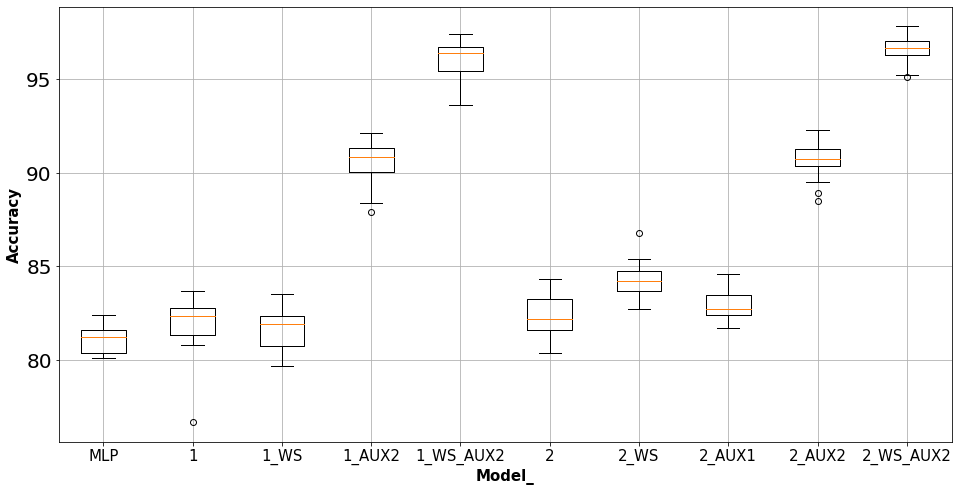

In [109]:
# Make a boxplot of the model experiments above
plt.figure(figsize=(16, 8))
plt.boxplot([x[0] for x in results], labels = ["_".join(x[1][0].replace("Model", "").strip().split(" ")) for x in results])
plt.grid(True)
plt.xlabel("Model_", fontsize= 15, fontweight = "bold")
plt.ylabel("Accuracy", fontsize= 15, fontweight = "bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.savefig("boxplot.png")
plt.show()

In [145]:
m = model_1_ws_aux2()
m.cuda()

accs = train_model(m, 
            x_train[list(range(1000))].to(device),
            y_train[list(range(1000))].to(device),
            y_train_classes[list(range(1000))].to(device),
            epochs = 25, 
            optimizer= torch.optim.Adam(m.parameters(), lr=0.0005), 
            batch_size = 16,
            output_length = 3)

In [146]:
evaluate_model(m, 
                x_test.to(device),
                y_test.to(device),
                y_test_classes.to(device),
                output_length = 3)

(93.7, 95.0, 93.89999999999999)

In [140]:
zeros = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
heat = torch.zeros(10, 10)

for i in range(10):
    for j in range(10):
        l = zeros.clone()
        l[i] = 1
        r = zeros.clone()
        r[j] = 1
        v = torch.softmax(m.dense2.forward(torch.cat((l, r), 0).to(device)), -1)[1].item()
        heat[i][j] = v

In [174]:
zeros = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
heat2 = torch.zeros(10, 10)

for i in range(10):
    for j in range(10):
        l = zeros.clone()
        if i == 0:
            l[i+1] += 0.25
        else:
            l[i-1] += 0.25
            
        if i == 9:
            l[i-1] += 0.25
        else :
            l[i+1] += 0.25
        l[i] += 0.5
        
        r = zeros.clone()
        if j == 0:
            r[j+1] += 0.25
        else:
            r[j-1] += 0.25
            
        if j == 9:
            r[j-1] += 0.25
        else :
            r[j+1] += 0.25
        r[j] += 0.5
        
        v = torch.softmax(m.dense2.forward(torch.cat((l, r), 0).to(device)), -1)[1].item()
        heat2[i][j] = v

In [180]:
left = torch.Tensor([0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0])
right = torch.Tensor([0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0])
heat3 = torch.zeros(10, 10)

for i in range(10):
    for j in range(10):
        l = left.clone()
        l[i] += 0.5
        
        r = right.clone()
        r[j] += 0.5
        
        v = torch.softmax(m.dense2.forward(torch.cat((l, r), 0).to(device)), -1)[1].item()
        heat3[i][j] = v

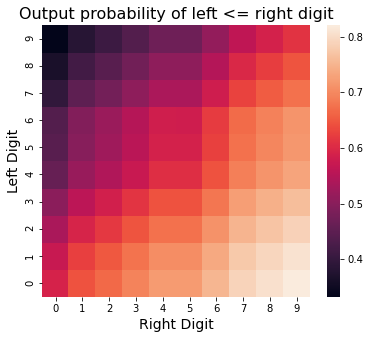

In [181]:
plt.figure(figsize=(6,5))

ax = sns.heatmap(heat3)
ax.invert_yaxis()
ax.set_title("Output probability of left <= right digit", fontsize= 16)
ax.set_xlabel("Right Digit", fontsize= 14)
ax.set_ylabel("Left Digit", fontsize= 14)
None
# plt.savefig("output_prob.png")

In [150]:
import seaborn as sns

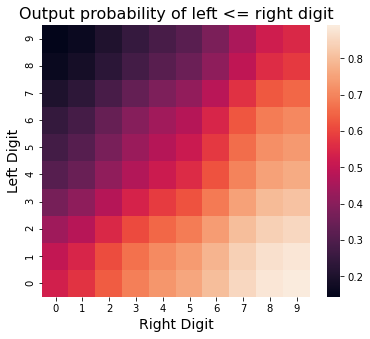

In [176]:
plt.figure(figsize=(6,5))

ax = sns.heatmap(heat2)
ax.invert_yaxis()
ax.set_title("Output probability of left <= right digit", fontsize= 16)
ax.set_xlabel("Right Digit", fontsize= 14)
ax.set_ylabel("Left Digit", fontsize= 14)
None
# plt.savefig("output_prob.png")

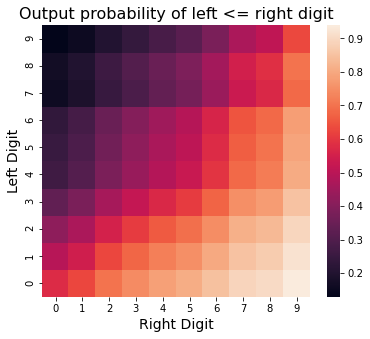

In [182]:
plt.figure(figsize=(6,5))

ax = sns.heatmap(heat)
ax.invert_yaxis()
ax.set_title("Output probability of left <= right digit", fontsize= 16)
ax.set_xlabel("Right Digit", fontsize= 14)
ax.set_ylabel("Left Digit", fontsize= 14)

plt.savefig("output_prob.png")

In [129]:
test = zeros.clone()
test[0] = 1
test

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [179]:
t1 = torch.Tensor([0.5, 0, 0, 0, 0.5, 0, 0, 0, 0, 0])
t2 = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5])

torch.softmax(m.dense2.forward(torch.cat((t1, t2), 0).to(device)), -1)[1].item()

0.8415480256080627

In [ ]:
t1 = torch.Tensor([0.5, 0, 0, 0, 0.5, 0, 0, 0, 0, 0])
t2 = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5])

torch.softmax(m.dense2.forward(torch.cat((t1, t2), 0).to(device)), -1)[1].item()

In [120]:
t1 = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
t1[0] = 1
t1

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])